In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import os
from datetime import datetime
import alphalens

from time import time
from pathlib import Path
import numpy as np
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVR
from sklearn.svm import LinearSVC
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score
import talib as ta
from alphalens.tears import create_summary_tear_sheet
from alphalens.utils import get_clean_factor_and_forward_returns

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import TimeSeriesSplit

In [2]:
import warnings
warnings.simplefilter('ignore')

### Creating Dataframe for prediction of Percent Returns on Open Price 

In [3]:
df_price = pd.read_csv('indicesweekly5y.csv')

In [4]:
df_price.shape

(1047, 8)

In [5]:
df_price['date'] = pd.to_datetime(df_price['Date'])
df_price['Year'] = pd.DatetimeIndex(df_price['date']).year

In [6]:
df_price

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,date,Year
0,2017-08-21,6241.209961,6308.720215,6241.209961,6265.640137,6265.640137,6190600000,IXIC,2017-08-21,2017
1,2017-08-28,6286.009766,6449.649902,6228.729980,6435.330078,6435.330078,8282150000,IXIC,2017-08-28,2017
2,2017-09-04,6414.819824,6426.509766,6334.589844,6360.189941,6360.189941,7576920000,IXIC,2017-09-04,2017
3,2017-09-11,6411.180176,6464.270020,6410.709961,6448.470215,6448.470215,10136760000,IXIC,2017-09-11,2017
4,2017-09-18,6460.100098,6477.770020,6400.810059,6426.919922,6426.919922,9148560000,IXIC,2017-09-18,2017
...,...,...,...,...,...,...,...,...,...,...
1042,2022-07-25,320.070007,329.269989,317.100006,328.660004,328.026978,15352800,DIA,2022-07-25,2022
1043,2022-08-01,326.910004,329.720001,323.899994,327.970001,327.338287,15802500,DIA,2022-08-01,2022
1044,2022-08-08,329.809998,337.920013,327.190002,337.829987,337.179291,12125800,DIA,2022-08-08,2022
1045,2022-08-15,336.109985,343.089996,336.059998,337.040009,336.390839,12654400,DIA,2022-08-15,2022


In [7]:
df_price.isna().any()

Date         False
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
Ticker       False
date         False
Year         False
dtype: bool

In [8]:
df_price.Year.min() , df_price.Year.max()

(2017, 2022)

In [9]:
df_price["Open"] = df_price.Open.abs()
df_price.set_index(["Ticker","date"], inplace=True)
df_price.sort_index(level=['Ticker','date'], ascending=True, inplace=True)

In [10]:
STOCKS = df_price.index.get_level_values('Ticker').unique()
Stk= STOCKS[0]
Stk

'DIA'

In [11]:
df_price

Date        Open        High         Low       Close  \
Ticker date                                                                     
DIA    2017-08-21  2017-08-21  217.410004  218.929993  217.300003  218.039993   
       2017-08-28  2017-08-28  218.500000  220.410004  216.619995  219.919998   
       2017-09-04  2017-09-04  219.529999  219.529999  217.179993  218.240005   
       2017-09-11  2017-09-11  219.580002  222.570007  219.580002  222.449997   
       2017-09-18  2017-09-18  222.919998  223.970001  222.669998  223.199997   
...                       ...         ...         ...         ...         ...   
SPY    2022-07-25  2022-07-25  395.750000  413.029999  389.950012  411.989990   
       2022-08-01  2022-08-01  409.149994  415.679993  406.820007  413.470001   
       2022-08-08  2022-08-08  415.250000  427.209991  410.220001  427.100006   
       2022-08-15  2022-08-15  424.769989  431.730011  421.220001  422.140015   
       2022-08-22  2022-08-22  417.049988  417.230011  412.399994  413.350006   

                    Adj Close     Volume  Year  
Ticker date                                     
DIA    2017-08-21  197.085617   10391100  2017  
       2017-08-28  198.784943    9565600  2017  
       2017-09-04  197.266434    9862700  2017  
       2017-09-11  201.071854   11084400  2017  
       2017-09-18  202.166183    9879800  2017  
...                       ...        ...   ...  
SPY    2022-07-25  411.989990  349807800  2022  
       2022-08-01  413.470001  303665700  2022  
       2022-08-08  427.100006  288617900  2022  
       2022-08-15  422.140015  293858600  2022  
       2022-08-22  413.350006   77695600  2022  

[1047 rows x 8 columns]

### Creating a loop to predict percent returns for each stock using LinearSVC

In [12]:
scaler = StandardScaler()
splitter = TimeSeriesSplit(n_splits=5)

In [13]:
def phi_k(y_true, y_pred):
    dfc = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    try:
        phi_k_corr = dfc.phik_matrix(interval_cols=[]).iloc[1,0]
        phi_k_sig  = dfc.significance_matrix(interval_cols=[]).iloc[1,0]
        phi_k_p_val = 1 - ndtr(phi_k_sig) 
    except:
        phi_k_corr = 0
        phi_k_p_val = 0
    #print(phi_k_corr)
    print(phi_k_p_val)
    return phi_k_corr

In [14]:
def information_coefficient(y_true, y_pred):
    rho, pval = spearmanr(y_true,y_pred) #spearman's rank correlation
    print (rho)
    return rho

def sharpe(y_true, y_pred):
    positions = np.where(y_pred> 0,1,-1 )
    dailyRet = pd.Series(positions).shift(1).fillna(0).values * y_true
    dailyRet = np.nan_to_num(dailyRet)
    ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet) / np.std(dailyRet)
    return ratio

In [15]:
myscorer = make_scorer(phi_k, greater_is_better=True)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


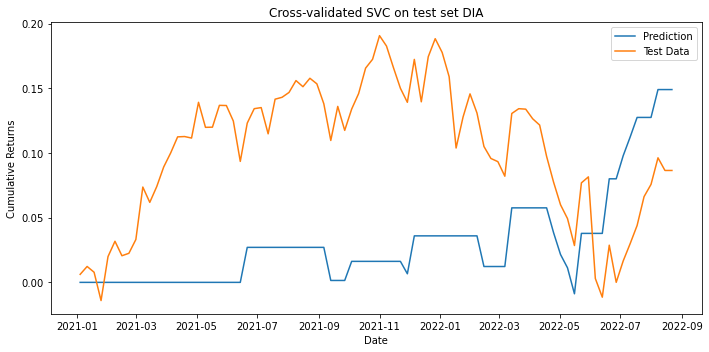

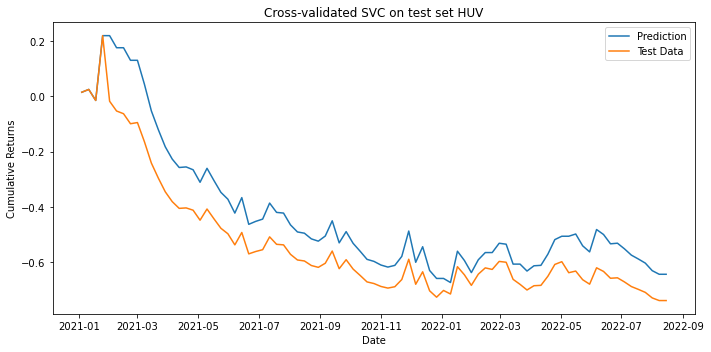

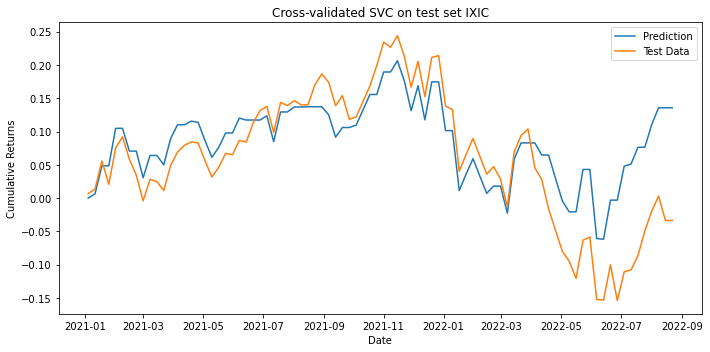

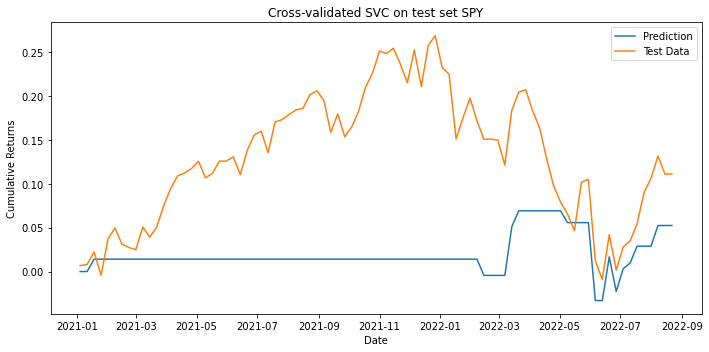

In [16]:
df2=[]
df = []
Spr = []
for i in STOCKS:
    df = df_price.loc[df_price.index.get_level_values('Ticker') == i]
    #df[n] = pd.DataFrame(df)
    openp = df['Open'].copy()
    close = df['Close'].copy()
    high = df['High'].shift(1)
    low = df['Low'].shift(1)
    close = df['Close'].shift(1)
    
    #Build features based on indicators

    n=10
    df['RSI']=ta.RSI(np.array(close), timeperiod=n)
    df['SMA'] = close.rolling(window=n).mean()
    df['Corr']= close.rolling(window=n).corr(df['SMA'])
    df['SAR']=ta.SAR(np.array(high),np.array(low), 0.2,0.2)
    df['ADX']=ta.ADX(np.array(high),np.array(low), np.array(df['Open']), timeperiod =n)
    df['OO']= df['Open']-df['Open'].shift(1)
    df['OC']= df['Open']-close
    df.fillna(0, inplace=True)
    
    for n in list(range(0,10)):
        name = 'lag_ret' + str(n)
        df[name] =  df['Open'].pct_change(1).shift(n).fillna(0)
    
    #build labels (0 and 1) based on percent returns of open price in the training set
    
    df['RetFut1'] = df['Open'].pct_change(1).shift(-1).fillna(0)
    df['label']=0
    df.loc[df['RetFut1']>df.RetFut1.loc[(df.Year.isin([2017,2018,2019,2020]))].quantile(q=0.51),'label']=1
    df1 = df.copy(deep=True)
    df=df.drop(['High','Low','Open','Close','Adj Close','Volume','Date'],axis=1)
    X_train = df[(df.Year.isin([2017,2018,2019,2020]))]
    X_test = df[(df.Year.isin([2021,2022]))]

    Y_train= X_train['label']
    RF_train = X_train['RetFut1']
    X_train= X_train.drop(['Year','RetFut1','label'],axis=1)

    Y_test = X_test['label']
    RF_test = X_test['RetFut1']
    X_test= X_test.drop(['Year','RetFut1','label'],axis=1)
    
    svc = LinearSVC() 

    pipe = Pipeline([("scaler", scaler), ("svc", svc)])

    c_rs = np.linspace(0.001, 1, num=8, endpoint=True); #1 default

    #set of parameters for random search
    param_grid = {'svc__C': c_rs}
    
    grid_search = RandomizedSearchCV(pipe, param_grid, cv=splitter,scoring=myscorer, return_train_score=True);
    
    #Grid Search to tune hyperparamter and determine the best values for each asset
    
    grid_search.fit(X_train.values, Y_train.values.ravel())

    best_parameters = grid_search.best_params_;
    best_model = grid_search.best_estimator_;

    positions1 = best_model.predict(X_train.values);  #Use best_model parameters for predictions

    dailyRet_tr = pd.Series(positions1).fillna(0).values * RF_train   #calcualate Percent Returns from predicted classes
    dailyRet_tr = dailyRet_tr.fillna(0)
    cumret_tr = np.cumprod(dailyRet_tr +1) - 1     # Calculate cumulative returns for train and test data based on  fitted model 
    
    positions2 = best_model.predict(X_test.values);
    
    dailyRet_ts = pd.Series(positions2).fillna(0).values * RF_test
    dailyRet_ts = dailyRet_ts.fillna(0)
    cumret_ts = np.cumprod(dailyRet_ts +1) - 1
    
    cumret_act = np.cumprod(RF_test +1) - 1
    
    plt.figure(figsize=(10,5))
    plt.plot(cumret_ts.index.get_level_values('date'), cumret_ts, label ='Prediction')   #plot the cumulative returns for comaprison (test set)
    plt.plot(cumret_ts.index.get_level_values('date'), cumret_act, label = 'Test Data')
    plt.title('Cross-validated SVC on test set ' + i)
    plt.ylabel('Cumulative Returns')
    plt.xlabel('Date')
    plt.legend()
    plt.tight_layout()
    S =stats.spearmanr(Y_test,positions2)[0]   # calculate Spearmann's rank coeff for each Asset and save
    Spr.append(S)
    
    #using predicted returns
    Retpred = pd.concat([dailyRet_tr,dailyRet_ts])
    Retpred.name = 'RetPred'
    Retpred = pd.DataFrame(Retpred)
    df=df1.join(Retpred,on = ['Ticker','date'], rsuffix='RetPred')
    df2.append(df)
    
    #using predicted continous probability predictions
    svc = LinearSVC(C=0.001)
    model = CalibratedClassifierCV(svc) #LinearSVC lacks a predict_proba method
    model.fit(X_train.values, Y_train.values.ravel())
    pred_proba_train = model.predict_proba(X_train.values)
    pred_proba_test = model.predict_proba(X_test.values)
    df_train = pd.DataFrame(pred_proba_train, columns=["downs","ups"])
    df_train["continuous_predictions"] = np.where(df_train["ups"]>df_train["downs"], df_train["ups"], -1*df_train["downs"])    
    df_test = pd.DataFrame(pred_proba_test, columns=["downs","ups"])
    df_test["continuous_predictions"] = np.where(df_test["ups"]>df_test["downs"], df_test["ups"], -1*df_test["downs"])    
    continuous_predictions = pd.concat([df_train["continuous_predictions"],df_test["continuous_predictions"]])  # combine train and test predicted returns for input factor
    
    #regardimg the next 3 lines of code: 
    #if you comment them out, you will be using the model's predited returns as aAphalens inputs
    #if you do not comment them out, you will be using the model's predicted probabilities as Alphalens inputs
    Retpred.Retpred = continuous_predictions.values #replace the predicted returns with the continous probabilty predictions
    df=df1.join(Retpred,on = ['Ticker','date'], rsuffix='RetPred')
    df2.append(df)

df3=pd.concat(list(df2),ignore_index = False) 

In [17]:
for i,s in zip(STOCKS,Spr):
    print("Spearmann Correlation of Asset ",i,' is ', s)

Spearmann Correlation of Asset  DIA  is  0.15840324413166007
Spearmann Correlation of Asset  HUV  is  -0.08225592997491435
Spearmann Correlation of Asset  IXIC  is  0.11692868075960146
Spearmann Correlation of Asset  SPY  is  0.20248703909386645


### Create factor and price data for Alphalens 

In [18]:
factor = pd.DataFrame(df3['RetPred'])
factor

RetPred
Ticker date                
DIA    2017-08-21  0.005014
       2017-08-28  0.004714
       2017-09-04  0.000228
       2017-09-11  0.015211
       2017-09-18  0.000852
...                     ...
SPY    2022-07-25  0.000000
       2022-08-01  0.000000
       2022-08-08  0.022926
       2022-08-15 -0.000000
       2022-08-22  0.000000

[2094 rows x 1 columns]

In [19]:
factors = factor.swaplevel().tz_localize('EST', level='date').sort_index()
factors = factors.drop_duplicates(keep='first')
factors = pd.DataFrame(factors)
factors[0:10]

RetPred
date                      Ticker          
2017-08-21 00:00:00-05:00 DIA     0.005014
                          HUV    -0.049255
                          IXIC    0.000000
                          SPY     0.006569
2017-08-28 00:00:00-05:00 DIA     0.004714
                          HUV     0.012048
                          SPY     0.008525
2017-09-04 00:00:00-05:00 DIA     0.000228
                          SPY     0.003155
2017-09-11 00:00:00-05:00 DIA     0.015211

In [20]:
price = df3.pivot_table(index = 'date', columns = 'Ticker',values='Open')
price.index = price.index.tz_localize('EST')
price.index.unique

<bound method Index.unique of DatetimeIndex(['2017-08-21 00:00:00-05:00', '2017-08-28 00:00:00-05:00',
               '2017-09-04 00:00:00-05:00', '2017-09-11 00:00:00-05:00',
               '2017-09-18 00:00:00-05:00', '2017-09-25 00:00:00-05:00',
               '2017-10-02 00:00:00-05:00', '2017-10-09 00:00:00-05:00',
               '2017-10-16 00:00:00-05:00', '2017-10-23 00:00:00-05:00',
               ...
               '2022-06-20 00:00:00-05:00', '2022-06-27 00:00:00-05:00',
               '2022-07-04 00:00:00-05:00', '2022-07-11 00:00:00-05:00',
               '2022-07-18 00:00:00-05:00', '2022-07-25 00:00:00-05:00',
               '2022-08-01 00:00:00-05:00', '2022-08-08 00:00:00-05:00',
               '2022-08-15 00:00:00-05:00', '2022-08-22 00:00:00-05:00'],
              dtype='datetime64[ns, EST]', name='date', length=262, freq=None)>

In [21]:
price.head()

Ticker,DIA,HUV,IXIC,SPY
date,,,,
2017-08-21 00:00:00-05:00,217.410004,87.300003,6241.209961,243.570007
2017-08-28 00:00:00-05:00,218.500000,83.000000,6286.009766,245.169998
2017-09-04 00:00:00-05:00,219.529999,84.000000,6414.819824,247.259995
2017-09-11 00:00:00-05:00,219.580002,82.199997,6411.180176,248.039993
2017-09-18 00:00:00-05:00,222.919998,74.500000,6460.100098,249.610001


In [22]:
#just provide the test set data so filter by testset dates
alpha_data = get_clean_factor_and_forward_returns(factor = factors.loc['2017-09-04':'2022-08-22'],
                                                    prices = price.loc['2017-09-04':'2022-08-22'],
                                                    quantiles=5,
                                                    periods=(1, 2, 3, 5, 10, 21),
                                                    max_loss = 60)
alpha_data.info()

Dropped 28.5% entries from factor data: 10.4% in forward returns computation and 18.1% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 6000.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 336 entries, (Timestamp('2017-09-04 00:00:00-0500', tz='EST', freq='C'), 'DIA') to (Timestamp('2022-03-21 00:00:00-0500', tz='EST', freq='C'), 'SPY')
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1D               336 non-null    float64
 1   2D               336 non-null    float64
 2   3D               336 non-null    float64
 3   5D               336 non-null    float64
 4   10D              336 non-null    float64
 5   21D              336 non-null    float64
 6   factor           336 non-null    float64
 7   factor_quantile  336 non-null    float64
dtypes: float64(8)
memory usage: 32.4+ KB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,-0.221061,0.107514,-0.028991,0.054134,133,39.583333
2.0,-0.078489,0.054556,-0.007076,0.042035,11,3.273810
3.0,-0.073782,0.120557,0.012766,0.033773,48,14.285714
4.0,-0.073071,0.062482,-0.001036,0.041249,11,3.273810
5.0,-0.029718,0.977186,0.049161,0.102890,133,39.583333


Returns Analysis


,1D,2D,3D,5D,10D,21D
Ann. alpha,4664.239,33.205,8.769,2.628,0.824,0.127
beta,0.569,0.584,0.620,-0.778,-0.877,-0.510
Mean Period Wise Return Top Quantile (bps),413.186,189.177,120.678,34.934,10.724,1.965
Mean Period Wise Return Bottom Quantile (bps),-368.330,-153.471,-101.715,-24.598,-2.337,-2.651
Mean Period Wise Spread (bps),781.516,336.851,216.065,59.425,32.426,3.015


Information Analysis


,1D,2D,3D,5D,10D,21D
IC Mean,1.000000e+00,0.517,0.347,0.226,0.302,0.143
IC Std.,0.000000e+00,0.783,0.840,0.867,0.849,0.930
Risk-Adjusted IC,1.202987e+16,0.661,0.414,0.260,0.356,0.154
t-stat(IC),NaN,NaN,NaN,NaN,NaN,NaN
p-value(IC),NaN,NaN,NaN,NaN,NaN,NaN
IC Skew,NaN,NaN,NaN,NaN,NaN,NaN
IC Kurtosis,NaN,NaN,NaN,NaN,NaN,NaN


Turnover Analysis


,1D,2D,3D,5D,10D,21D
Quantile 1 Mean Turnover,0.667,0.641,0.623,0.676,0.698,0.725
Quantile 2 Mean Turnover,1.000,NaN,0.000,NaN,NaN,NaN
Quantile 3 Mean Turnover,0.385,0.615,0.750,0.455,0.375,0.300
Quantile 4 Mean Turnover,1.000,NaN,0.000,NaN,NaN,NaN
Quantile 5 Mean Turnover,0.679,0.603,0.652,0.794,0.619,0.710


,1D,2D,3D,5D,10D,21D
Mean Factor Rank Autocorrelation,-0.036,0.096,0.052,-0.249,-0.099,-0.077


<Figure size 432x288 with 0 Axes>

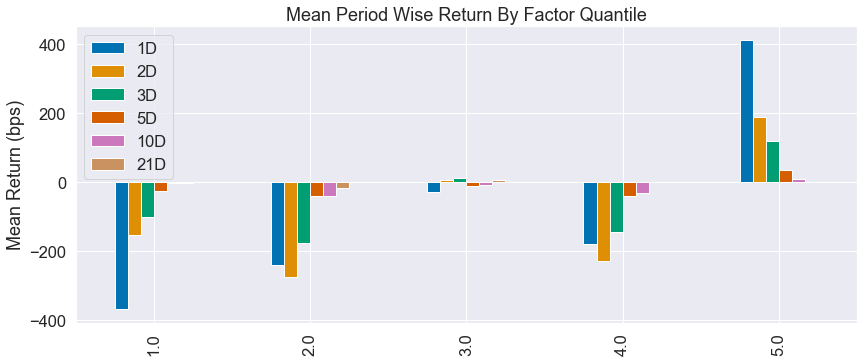

In [23]:
create_summary_tear_sheet(alpha_data)

In [24]:
alpha_data.head(15)

1D        2D        3D        5D  \
date                      asset                                           
2017-09-04 00:00:00-05:00 DIA    0.000228  0.015442  0.016308  0.038081   
                          SPY    0.003155  0.009504  0.007644  0.029807   
2017-09-11 00:00:00-05:00 DIA    0.015211  0.016076  0.020995  0.043219   
                          SPY    0.006330  0.004475  0.013909  0.028907   
2017-09-18 00:00:00-05:00 DIA    0.000852  0.005697  0.022295  0.047820   
                          SPY   -0.001843  0.007532  0.020111  0.031529   
2017-09-25 00:00:00-05:00 DIA    0.004841  0.021424  0.026713  0.046659   
                          SPY    0.009392  0.021995  0.024323  0.029380   
2017-10-02 00:00:00-05:00 DIA    0.016504  0.021767  0.041884  0.049244   
                          SPY    0.012486  0.014792  0.023818  0.027079   
2017-10-09 00:00:00-05:00 DIA    0.005178  0.024968  0.024705  0.025319   
                          SPY    0.002278  0.011193  0.007226  0.010525   
2017-10-16 00:00:00-05:00 DIA    0.019688  0.019426  0.026891  0.020038   
                          SPY    0.008895  0.004937  0.012108  0.011481   
2017-10-23 00:00:00-05:00 DIA   -0.000257  0.007064  0.000343  0.008220   

                                      10D       21D    factor  factor_quantile  
date                      asset                                                 
2017-09-04 00:00:00-05:00 DIA    0.064365  0.209675  0.000228              1.0  
                          SPY    0.040645  0.156394  0.003155              5.0  
2017-09-11 00:00:00-05:00 DIA    0.064122  0.148647  0.015211              5.0  
                          SPY    0.040719  0.102443  0.006330              1.0  
2017-09-18 00:00:00-05:00 DIA    0.056433  0.094698  0.000852              5.0  
                          SPY    0.043268  0.056969 -0.001843              1.0  
2017-09-25 00:00:00-05:00 DIA    0.098158  0.122496  0.004841              1.0  
                          SPY    0.068874  0.091832  0.009392              5.0  
2017-10-02 00:00:00-05:00 DIA    0.087337  0.134395  0.016504              5.0  
                          SPY    0.058929  0.097181  0.012486              1.0  
2017-10-09 00:00:00-05:00 DIA    0.088288  0.069990  0.005178              5.0  
                          SPY    0.052900  0.051447  0.002278              1.0  
2017-10-16 00:00:00-05:00 DIA    0.078011  0.109050  0.019688              5.0  
                          SPY    0.046393  0.094001  0.008895              1.0  
2017-10-23 00:00:00-05:00 DIA    0.063190  0.063019 -0.000257              3.0

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,-0.221061,0.107514,-0.028991,0.054134,133,39.583333
2.0,-0.078489,0.054556,-0.007076,0.042035,11,3.273810
3.0,-0.073782,0.120557,0.012766,0.033773,48,14.285714
4.0,-0.073071,0.062482,-0.001036,0.041249,11,3.273810
5.0,-0.029718,0.977186,0.049161,0.102890,133,39.583333


Returns Analysis


,1D,2D,3D,5D,10D,21D
Ann. alpha,4664.239,33.205,8.769,2.628,0.824,0.127
beta,0.569,0.584,0.620,-0.778,-0.877,-0.510
Mean Period Wise Return Top Quantile (bps),413.186,189.177,120.678,34.934,10.724,1.965
Mean Period Wise Return Bottom Quantile (bps),-368.330,-153.471,-101.715,-24.598,-2.337,-2.651
Mean Period Wise Spread (bps),781.516,336.851,216.065,59.425,32.426,3.015


<Figure size 432x288 with 0 Axes>

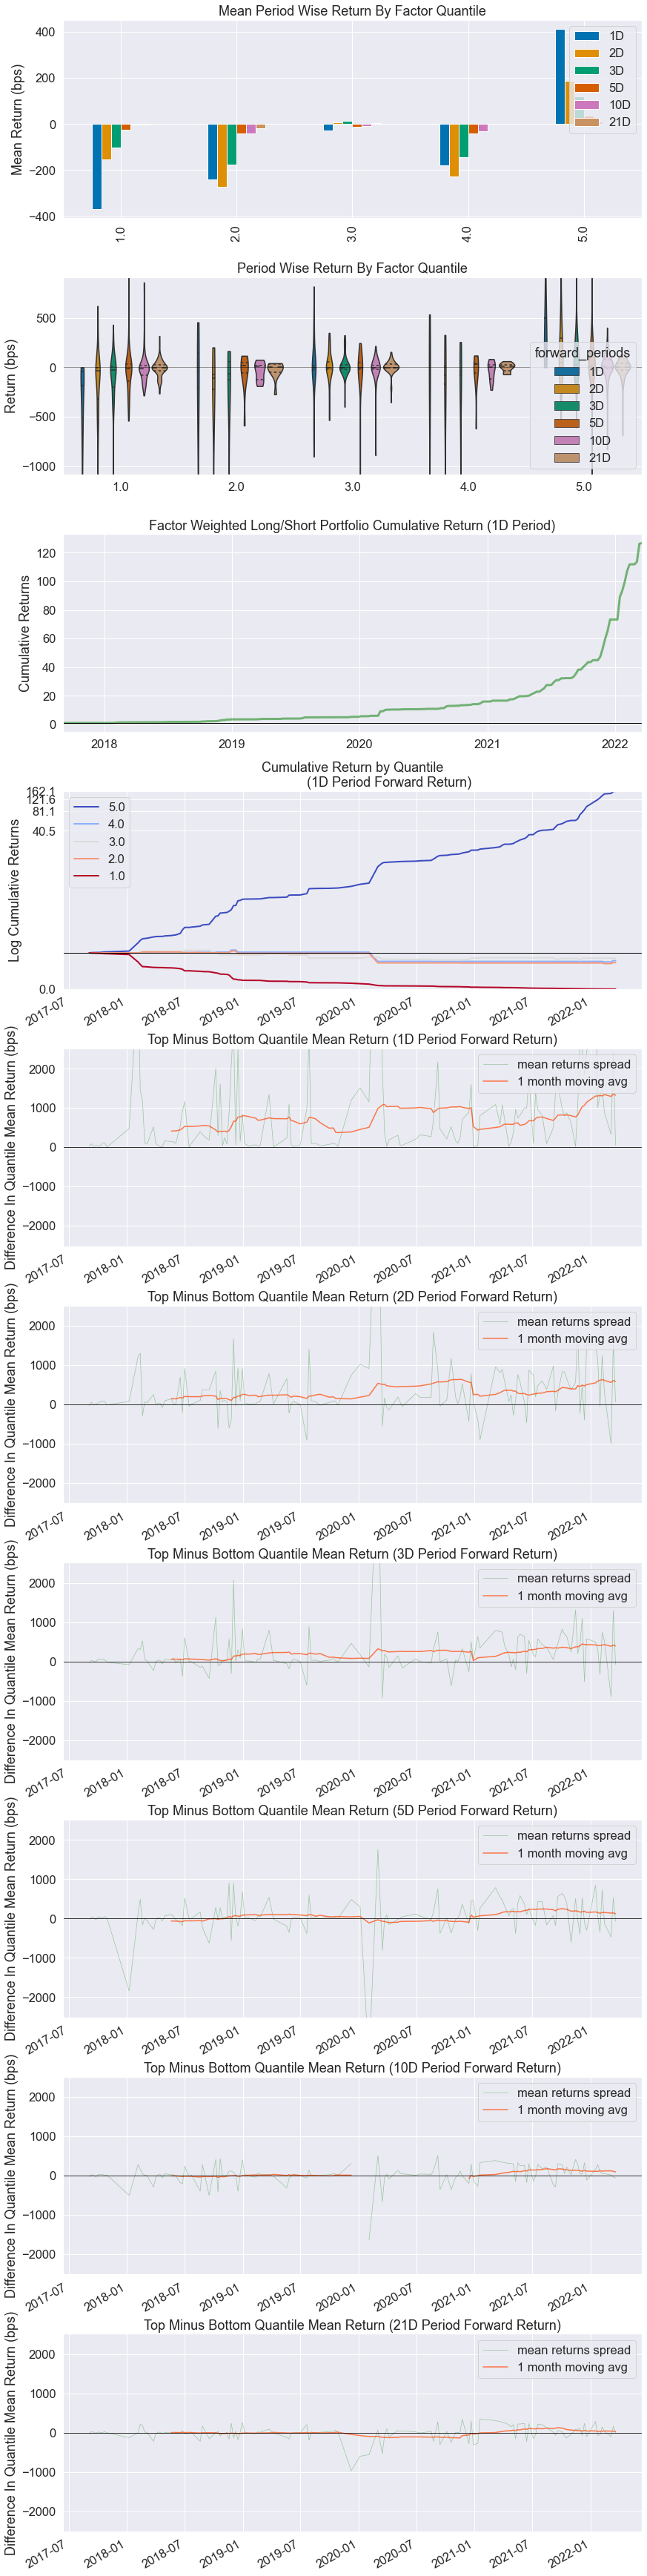

Information Analysis


,1D,2D,3D,5D,10D,21D
IC Mean,1.000000e+00,0.517,0.347,0.226,0.302,0.143
IC Std.,0.000000e+00,0.783,0.840,0.867,0.849,0.930
Risk-Adjusted IC,1.202987e+16,0.661,0.414,0.260,0.356,0.154
t-stat(IC),NaN,NaN,NaN,NaN,NaN,NaN
p-value(IC),NaN,NaN,NaN,NaN,NaN,NaN
IC Skew,NaN,NaN,NaN,NaN,NaN,NaN
IC Kurtosis,NaN,NaN,NaN,NaN,NaN,NaN


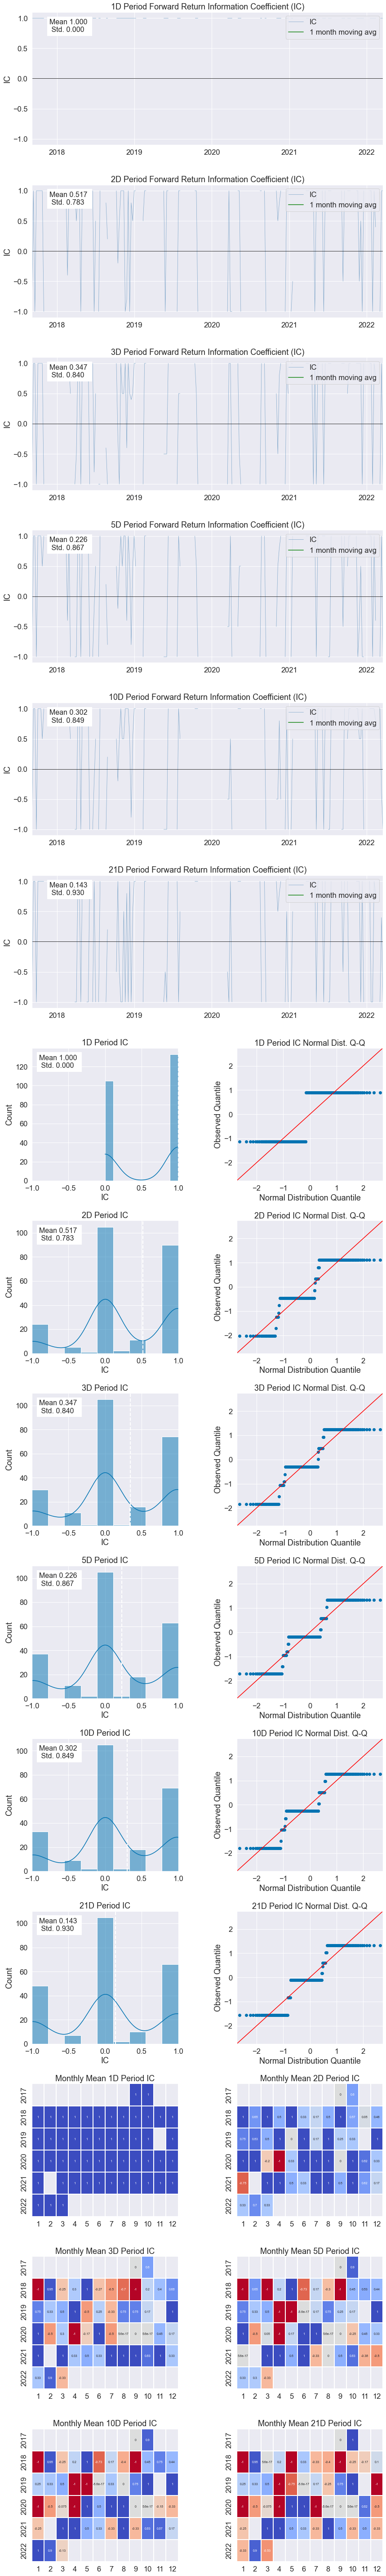

Turnover Analysis


,1D,2D,3D,5D,10D,21D
Quantile 1.0 Mean Turnover,0.667,0.641,0.623,0.676,0.698,0.725
Quantile 2.0 Mean Turnover,1.000,NaN,0.000,NaN,NaN,NaN
Quantile 3.0 Mean Turnover,0.385,0.615,0.750,0.455,0.375,0.300
Quantile 4.0 Mean Turnover,1.000,NaN,0.000,NaN,NaN,NaN
Quantile 5.0 Mean Turnover,0.679,0.603,0.652,0.794,0.619,0.710


,1D,2D,3D,5D,10D,21D
Mean Factor Rank Autocorrelation,-0.036,0.096,0.052,-0.249,-0.099,-0.077


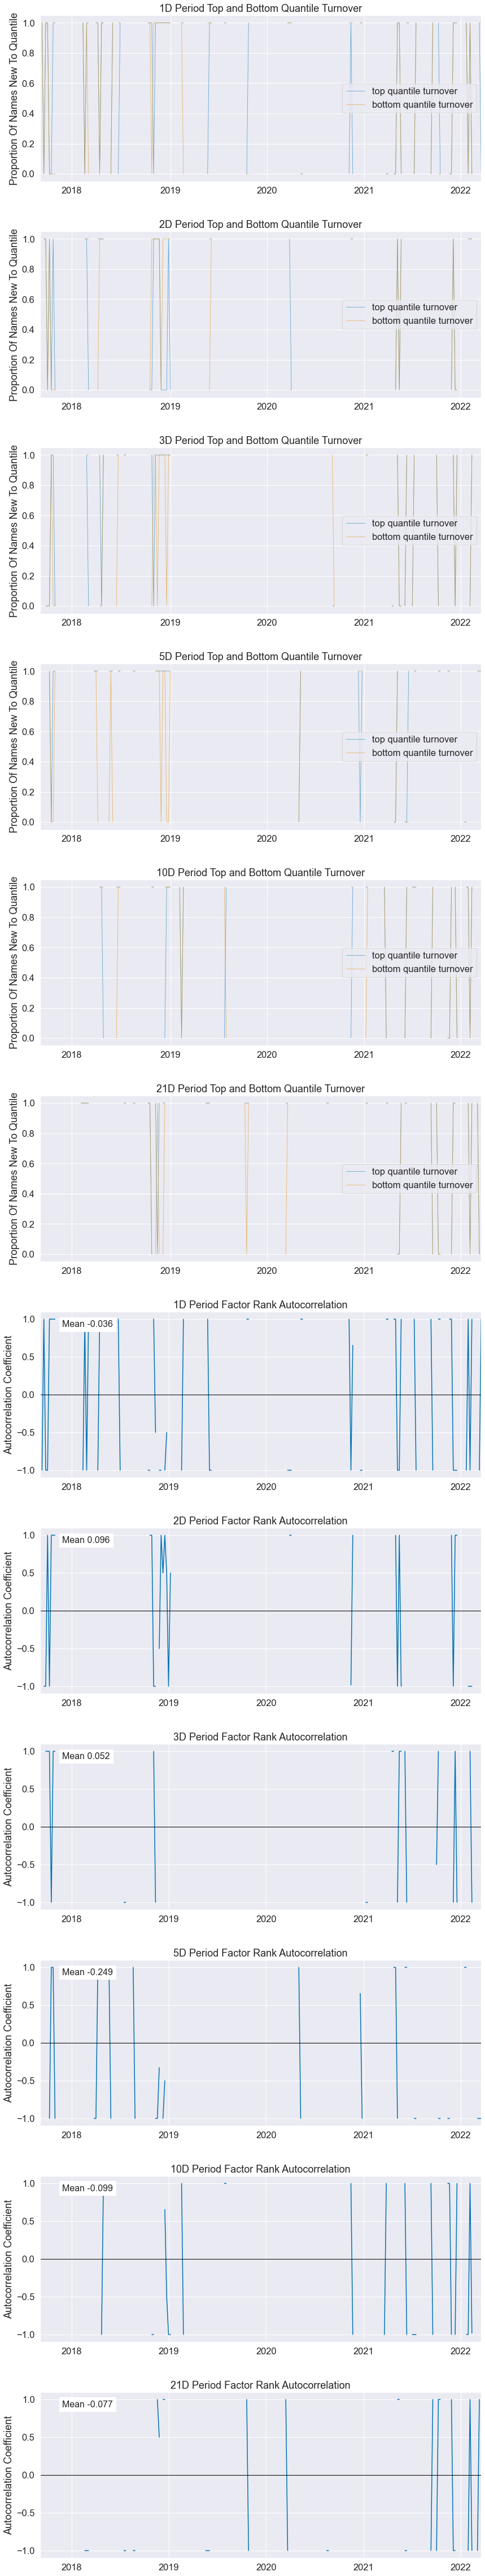

In [28]:
from alphalens.tears import create_full_tear_sheet
alphalens.tears.create_full_tear_sheet(alpha_data, long_short=True, group_neutral=False, by_group=False)